### Importing Necessary Libraries

In [220]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [221]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [222]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [223]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [224]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [225]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [226]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [227]:
fine_tune_data_resnet = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_resnet.shape

(16000, 5, 2048)

In [228]:
N_COMPS_1 = 1300 # 1600
N_COMPS_2 = 300 # 400
N_COMPS_3 = 900 # 1000
random_state=43

In [229]:

pcas_resnet = [PCA(N_COMPS_1, random_state=random_state) for _ in range(5)]

In [230]:
for i in range(5):
    pcas_resnet[i].fit(fine_tune_data_resnet[:,i,:])

In [231]:
fine_tune_data_train_red_resnet = np.zeros((fine_tune_data_resnet.shape[0], 5, N_COMPS_1))
for i in range(5):
    fine_tune_data_train_red_resnet[:,i,:] = pcas_resnet[i].transform(fine_tune_data_resnet[:,i,:])
fine_tune_data_resnet = fine_tune_data_train_red_resnet
del fine_tune_data_train_red_resnet

In [232]:
fine_tune_data_resnet.shape

(16000, 5, 1300)

In [233]:
fine_tune_data_vgg = np.load('./Data/VGG16-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_vgg.shape

(16000, 5, 512)

In [234]:

pcas_vgg = [PCA(N_COMPS_2, random_state=random_state) for _ in range(5)]

In [235]:
for i in range(5):
    pcas_vgg[i].fit(fine_tune_data_vgg[:,i,:])

In [236]:
fine_tune_data_train_red_vgg = np.zeros((fine_tune_data_vgg.shape[0], 5, N_COMPS_2))
for i in range(5):
    fine_tune_data_train_red_vgg[:,i,:] = pcas_vgg[i].transform(fine_tune_data_vgg[:,i,:])
fine_tune_data_vgg = fine_tune_data_train_red_vgg
del fine_tune_data_train_red_vgg
fine_tune_data_vgg.shape

(16000, 5, 300)

In [237]:
fine_tune_data_inception_resnet = np.load('./Data/Inception-ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data_inception_resnet.shape

(16000, 5, 1536)

In [238]:

pcas_inception_resnet = [PCA(N_COMPS_3, random_state=random_state) for _ in range(5)]

In [239]:
for i in range(5):
    pcas_inception_resnet[i].fit(fine_tune_data_inception_resnet[:,i,:])

In [240]:
fine_tune_data_train_red_inception_resnet = np.zeros((fine_tune_data_inception_resnet.shape[0], 5, N_COMPS_3))
for i in range(5):
    fine_tune_data_train_red_inception_resnet[:,i,:] = pcas_inception_resnet[i].transform(fine_tune_data_inception_resnet[:,i,:])
fine_tune_data_inception_resnet = fine_tune_data_train_red_inception_resnet
del fine_tune_data_train_red_inception_resnet
fine_tune_data_inception_resnet.shape

(16000, 5, 900)

In [241]:
fine_tune_data = np.concatenate([fine_tune_data_resnet, fine_tune_data_vgg, fine_tune_data_inception_resnet], axis=-1)
fine_tune_data.shape

(16000, 5, 2500)

In [242]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [243]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 2500)

In [244]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [245]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 2500)

In [246]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [247]:
def ftmodel():
    inputs = Input(shape=(5, N_COMPS_1 + N_COMPS_2 + N_COMPS_3))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    # x = Dense(256, name='top_dense_3', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(top_dropout_rate, name='top_dropout_4')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='RestNet-VGG-Inception-ResNet-FineTune')
    return model1

In [248]:
model1 = ftmodel()
model1.summary()

Model: "RestNet-VGG-Inception-ResNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 5, 2500)]         0         
                                                                 
 flatten_4 (Flatten)         (None, 12500)             0         
                                                                 
 batch_normalization_8 (Batc  (None, 12500)            50000     
 hNormalization)                                                 
                                                                 
 top_dropout_2 (Dropout)     (None, 12500)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               6400512   
                                                                 
 batch_normalization_9 (Batc  (None, 512)              2048      
 hNormalization)             

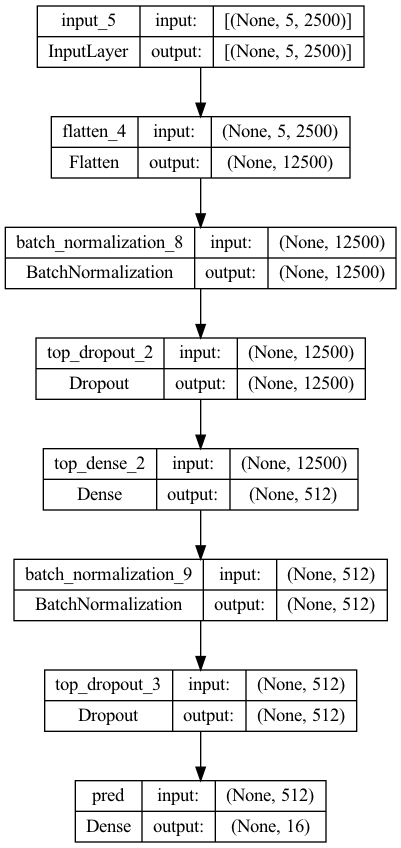

In [249]:
tf.keras.utils.plot_model(model1, show_shapes=True, to_file='./Images/ResNet-VGG-Inception-ResNet-4Piece-PCA-Model.png')

### Model Training

The fine-tuning will be done on the ResNet+VGG+Inception-ResNet's PCA reduced $1024D+256D+768D$ representation vectors.

In [250]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [251]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/ResNet-VGG-Inception-ResNet-4P/auto-ResNet-VGG-Inception-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [252]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-VGG-Inception-ResNet-4P/resnet-vgg-inception-resnet-4p-model-weights")
model1.load_weights('./Models/ResNet-VGG-Inception-ResNet-4P/resnet-vgg-inception-resnet-4p-model-weights')

Epoch 1/1000


2022-10-09 15:49:05.324599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


18/19 [===========================>..] - ETA: 0s - loss: 3.2938 - accuracy: 0.2027

2022-10-09 15:49:06.792927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 2s 84ms/step - loss: 3.2484 - accuracy: 0.2113 - val_loss: 1.5581 - val_accuracy: 0.5875
Epoch 2/1000
19/19 [==============================] - 1s 36ms/step - loss: 1.6424 - accuracy: 0.5553 - val_loss: 1.3209 - val_accuracy: 0.6513
Epoch 3/1000
19/19 [==============================] - 1s 37ms/step - loss: 1.1199 - accuracy: 0.6949 - val_loss: 1.1850 - val_accuracy: 0.6912
Epoch 4/1000
19/19 [==============================] - 1s 30ms/step - loss: 0.8680 - accuracy: 0.7616 - val_loss: 1.0946 - val_accuracy: 0.7225
Epoch 5/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.7042 - accuracy: 0.8087 - val_loss: 1.0307 - val_accuracy: 0.7362
Epoch 6/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5991 - accuracy: 0.8413 - val_loss: 0.9849 - val_accuracy: 0.7450
Epoch 7/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.5176 - accuracy: 0.8659 - val_loss: 0.9468 - val_accuracy: 0.7512
Epoch 8/1000

19/19 [==============================] - 0s 17ms/step - loss: 0.0926 - accuracy: 0.9916 - val_loss: 0.8816 - val_accuracy: 0.8137
Epoch 59/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.0889 - accuracy: 0.9914 - val_loss: 0.8867 - val_accuracy: 0.8175
Epoch 60/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.0884 - accuracy: 0.9924 - val_loss: 0.8901 - val_accuracy: 0.8187
Epoch 61/1000
19/19 [==============================] - 1s 32ms/step - loss: 0.0874 - accuracy: 0.9930 - val_loss: 0.8941 - val_accuracy: 0.8175
Epoch 62/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0901 - accuracy: 0.9920 - val_loss: 0.8918 - val_accuracy: 0.8150
Epoch 63/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0874 - accuracy: 0.9930 - val_loss: 0.8947 - val_accuracy: 0.8137
Epoch 64/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0880 - accuracy: 0.9927 - val_loss: 0.8897 - val_accuracy: 0.8137
Epoch 

Epoch 115/1000
19/19 [==============================] - 1s 28ms/step - loss: 0.0760 - accuracy: 0.9965 - val_loss: 0.9572 - val_accuracy: 0.8100
Epoch 116/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0761 - accuracy: 0.9961 - val_loss: 0.9558 - val_accuracy: 0.8100
Epoch 117/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0779 - accuracy: 0.9955 - val_loss: 0.9566 - val_accuracy: 0.8175
Epoch 118/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0766 - accuracy: 0.9966 - val_loss: 0.9512 - val_accuracy: 0.8162
Epoch 119/1000
19/19 [==============================] - 0s 19ms/step - loss: 0.0801 - accuracy: 0.9947 - val_loss: 0.9519 - val_accuracy: 0.8175
Epoch 120/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0771 - accuracy: 0.9953 - val_loss: 0.9583 - val_accuracy: 0.8162
Epoch 121/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0771 - accuracy: 0.9952 - val_loss: 0.9635 - val_ac

19/19 [==============================] - 0s 17ms/step - loss: 0.0799 - accuracy: 0.9970 - val_loss: 0.9391 - val_accuracy: 0.8150
Epoch 228/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0789 - accuracy: 0.9974 - val_loss: 0.9413 - val_accuracy: 0.8150
Epoch 229/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0796 - accuracy: 0.9968 - val_loss: 0.9356 - val_accuracy: 0.8137
Epoch 230/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0810 - accuracy: 0.9964 - val_loss: 0.9281 - val_accuracy: 0.8200
Epoch 231/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0804 - accuracy: 0.9963 - val_loss: 0.9348 - val_accuracy: 0.8137
Epoch 232/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0810 - accuracy: 0.9972 - val_loss: 0.9396 - val_accuracy: 0.8112
Epoch 233/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0803 - accuracy: 0.9970 - val_loss: 0.9389 - val_accuracy: 0.8175


19/19 [==============================] - 0s 17ms/step - loss: 0.0850 - accuracy: 0.9970 - val_loss: 0.9462 - val_accuracy: 0.8200
Epoch 340/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0843 - accuracy: 0.9978 - val_loss: 0.9503 - val_accuracy: 0.8225
Epoch 341/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0862 - accuracy: 0.9968 - val_loss: 0.9510 - val_accuracy: 0.8162
Epoch 342/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0853 - accuracy: 0.9970 - val_loss: 0.9399 - val_accuracy: 0.8187
Epoch 343/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0851 - accuracy: 0.9976 - val_loss: 0.9371 - val_accuracy: 0.8175
Epoch 344/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0861 - accuracy: 0.9968 - val_loss: 0.9338 - val_accuracy: 0.8212
Epoch 345/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0866 - accuracy: 0.9961 - val_loss: 0.9319 - val_accuracy: 0.8275


19/19 [==============================] - 0s 16ms/step - loss: 0.0888 - accuracy: 0.9973 - val_loss: 0.9789 - val_accuracy: 0.8212
Epoch 452/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0881 - accuracy: 0.9980 - val_loss: 0.9790 - val_accuracy: 0.8212
Epoch 453/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0876 - accuracy: 0.9976 - val_loss: 0.9753 - val_accuracy: 0.8275
Epoch 454/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0888 - accuracy: 0.9974 - val_loss: 0.9731 - val_accuracy: 0.8237
Epoch 455/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0877 - accuracy: 0.9981 - val_loss: 0.9751 - val_accuracy: 0.8237
Epoch 456/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0909 - accuracy: 0.9968 - val_loss: 0.9785 - val_accuracy: 0.8225
Epoch 457/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0875 - accuracy: 0.9980 - val_loss: 0.9767 - val_accuracy: 0.8187


19/19 [==============================] - 0s 16ms/step - loss: 0.0904 - accuracy: 0.9980 - val_loss: 0.9932 - val_accuracy: 0.8125
Epoch 564/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0925 - accuracy: 0.9973 - val_loss: 0.9847 - val_accuracy: 0.8100
Epoch 565/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0918 - accuracy: 0.9978 - val_loss: 0.9777 - val_accuracy: 0.8075
Epoch 566/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0919 - accuracy: 0.9974 - val_loss: 0.9910 - val_accuracy: 0.8075
Epoch 567/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0922 - accuracy: 0.9976 - val_loss: 0.9915 - val_accuracy: 0.8075
Epoch 568/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0904 - accuracy: 0.9980 - val_loss: 0.9914 - val_accuracy: 0.8025
Epoch 569/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0924 - accuracy: 0.9974 - val_loss: 0.9911 - val_accuracy: 0.8050


19/19 [==============================] - 0s 17ms/step - loss: 0.0906 - accuracy: 0.9984 - val_loss: 0.9516 - val_accuracy: 0.8200
Epoch 676/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0919 - accuracy: 0.9976 - val_loss: 0.9502 - val_accuracy: 0.8162
Epoch 677/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0926 - accuracy: 0.9976 - val_loss: 0.9500 - val_accuracy: 0.8137
Epoch 678/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0897 - accuracy: 0.9983 - val_loss: 0.9534 - val_accuracy: 0.8150
Epoch 679/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0916 - accuracy: 0.9974 - val_loss: 0.9530 - val_accuracy: 0.8087
Epoch 680/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0917 - accuracy: 0.9983 - val_loss: 0.9543 - val_accuracy: 0.8112
Epoch 681/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0923 - accuracy: 0.9974 - val_loss: 0.9529 - val_accuracy: 0.8162


19/19 [==============================] - 0s 18ms/step - loss: 0.0915 - accuracy: 0.9980 - val_loss: 0.9028 - val_accuracy: 0.8187
Epoch 788/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0939 - accuracy: 0.9974 - val_loss: 0.9033 - val_accuracy: 0.8237
Epoch 789/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0938 - accuracy: 0.9973 - val_loss: 0.9001 - val_accuracy: 0.8250
Epoch 790/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0948 - accuracy: 0.9967 - val_loss: 0.9051 - val_accuracy: 0.8225
Epoch 791/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0942 - accuracy: 0.9972 - val_loss: 0.9135 - val_accuracy: 0.8162
Epoch 792/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0924 - accuracy: 0.9984 - val_loss: 0.9214 - val_accuracy: 0.8162
Epoch 793/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0924 - accuracy: 0.9980 - val_loss: 0.9182 - val_accuracy: 0.8150


19/19 [==============================] - 0s 18ms/step - loss: 0.0916 - accuracy: 0.9980 - val_loss: 0.9670 - val_accuracy: 0.8212
Epoch 900/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0928 - accuracy: 0.9978 - val_loss: 0.9662 - val_accuracy: 0.8200
Epoch 901/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0933 - accuracy: 0.9973 - val_loss: 0.9596 - val_accuracy: 0.8200
Epoch 902/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0925 - accuracy: 0.9974 - val_loss: 0.9613 - val_accuracy: 0.8137
Epoch 903/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0936 - accuracy: 0.9972 - val_loss: 0.9516 - val_accuracy: 0.8175
Epoch 904/1000
19/19 [==============================] - 0s 18ms/step - loss: 0.0920 - accuracy: 0.9979 - val_loss: 0.9458 - val_accuracy: 0.8162
Epoch 905/1000
19/19 [==============================] - 0s 17ms/step - loss: 0.0932 - accuracy: 0.9976 - val_loss: 0.9429 - val_accuracy: 0.8237


In [253]:
model1.load_weights('./Models/ResNet-VGG-Inception-ResNet-4P/auto-ResNet-VGG-Inception-ResNet-FT-model-weight')

In [254]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

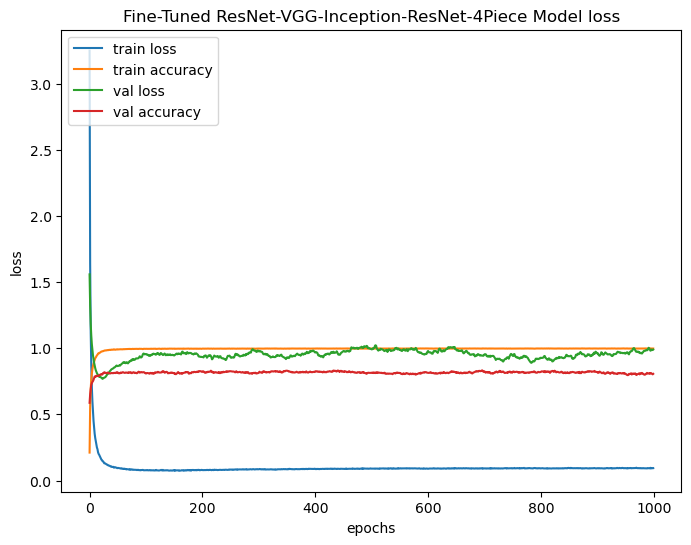

In [255]:
plot_train_loss(history, 'Fine-Tuned ResNet-VGG-Inception-ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [256]:
train_preds = model1.predict(fine_tune_data_train)

 57/475 [==>...........................] - ETA: 1s

2022-10-09 15:56:49.262692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 2s 4ms/step


In [257]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [258]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [259]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [260]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
9198,9682,./Data/train/train/9682.tif,12
12255,12896,./Data/train/train/12896.tif,9


In [261]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,0.997814,1.000000,0.998906,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [262]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 4ms/step


In [263]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [264]:
test_pred_labels

array([11,  8,  0,  1, 10,  9, 13, 12, 14,  1,  6,  0,  0, 14,  1, 11,  0,
        9,  6, 13,  8, 14,  3, 12,  6,  0,  3,  5,  3,  3, 15,  1,  9,  2,
        5,  8,  4,  7, 11,  9,  6, 12, 14,  2,  5, 14,  5,  0, 13,  4,  0,
       10,  5,  0, 11, 14, 15,  9,  9,  2, 15, 13,  2, 11,  6, 10,  8,  0,
        6,  3,  4,  4, 12,  0,  8,  6,  7,  0, 12, 11, 11,  0, 12, 12,  9,
        8,  1, 13, 13, 13, 10, 11,  4, 10,  1,  7, 11,  8, 13, 10,  3, 11,
       12,  9,  7, 14,  8,  2,  5, 15,  7,  5,  9,  4, 12, 12, 12, 13, 11,
        6, 13,  1,  0, 12,  1,  5, 13, 12,  0, 14,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8, 11, 12,  8,  5,  8,  9,  2, 13, 15, 14,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 12, 13,  8,  2,  8,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 10, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 13, 10, 11, 11, 10, 13,  9,  1,
        9,  5, 13, 14, 12,  1,  4,  8,  7,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  1,  7,  5

In [265]:
np.sum(test_pred_labels == test_labels['label'])

651

In [266]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
2,33,./Data/train/train/33.tif,6
4,65,./Data/train/train/65.tif,14
7,100,./Data/train/train/100.tif,10
11,164,./Data/train/train/164.tif,15
12,179,./Data/train/train/179.tif,7
...,...,...,...
764,15341,./Data/train/train/15341.tif,7
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
784,15596,./Data/train/train/15596.tif,8


In [267]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.771930,0.814815,0.792793,54
1,0.653061,0.727273,0.688172,44
2,0.886364,0.906977,0.896552,43
3,0.954545,0.913043,0.933333,46
4,0.885714,0.861111,0.873239,36
5,0.717391,0.660000,0.687500,50
6,0.928571,0.847826,0.886364,46
7,0.854167,0.788462,0.820000,52
8,0.844828,0.907407,0.875000,54
9,0.812500,0.829787,0.821053,47


In [268]:
np.mean(fscore)

0.8141554511573338

#### On Validation Data

Generating Predictions for the Validation Set

In [269]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [270]:
fine_tune_data_validation_resnet = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_resnet.shape

(900, 5, 2048)

In [271]:
fine_tune_data_validation_vgg = np.load('./Data/VGG16-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_vgg.shape

(900, 5, 512)

In [272]:
fine_tune_data_validation_inception_resnet = np.load('./Data/Inception-ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation_inception_resnet.shape

(900, 5, 1536)

In [273]:
fine_tune_data_validation_red_resnet = np.zeros((fine_tune_data_validation_resnet.shape[0], 5, N_COMPS_1))
for i in range(5):
    fine_tune_data_validation_red_resnet[:,i,:] = pcas_resnet[i].transform(fine_tune_data_validation_resnet[:,i,:])
fine_tune_data_validation_resnet = fine_tune_data_validation_red_resnet
del fine_tune_data_validation_red_resnet
fine_tune_data_validation_resnet.shape

(900, 5, 1300)

In [274]:
fine_tune_data_validation_red_vgg = np.zeros((fine_tune_data_validation_vgg.shape[0], 5, N_COMPS_2))
for i in range(5):
    fine_tune_data_validation_red_vgg[:,i,:] = pcas_vgg[i].transform(fine_tune_data_validation_vgg[:,i,:])
fine_tune_data_validation_vgg = fine_tune_data_validation_red_vgg
del fine_tune_data_validation_red_vgg
fine_tune_data_validation_vgg.shape

(900, 5, 300)

In [275]:
fine_tune_data_validation_red_inception_resnet = np.zeros((fine_tune_data_validation_inception_resnet.shape[0], 5, N_COMPS_3))
for i in range(5):
    fine_tune_data_validation_red_inception_resnet[:,i,:] = pcas_inception_resnet[i].transform(fine_tune_data_validation_inception_resnet[:,i,:])
fine_tune_data_validation_inception_resnet = fine_tune_data_validation_red_inception_resnet
del fine_tune_data_validation_red_inception_resnet
fine_tune_data_validation_inception_resnet.shape

(900, 5, 900)

In [276]:
fine_tune_data_validation = np.concatenate([fine_tune_data_validation_resnet, fine_tune_data_validation_vgg, fine_tune_data_validation_inception_resnet], axis=-1)
fine_tune_data_validation.shape

(900, 5, 2500)

In [277]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 3ms/step


2022-10-09 15:57:30.272902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [278]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [279]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,10


In [280]:
submission_data.to_csv('./Submissions/submission-resnet-vgg-inception-4p.csv', index=False)